Creative Commons CC BY 4.0 Lynd Bacon & Associates, Ltd. Not warranted to be suitable for any particular purpose. (You're on your own!)

# Unsupervised Learning

Many ML applications involve _supervised_ learning.  There's a target variable to be predicted, and "labels" (values) on the target are available.

_Unsupervised_ learning problems are those in which there is no target variable with labels.  In a sense the problem consists of trying to predict labels a set of observations that indicate membership in a particular group or, "cluster," of observations.  The number of such classes is usually known a priori.  Discovering what it most likely is for a particular set of data is a critical part of the learning problem. 

_Clustering methods_ are the class of algorithms that are used for unsupervised learning problems.  There are many, including:

* K-centroids clustering
* Hierarchical clustering
* Model-based, or mixture, clustering
* Copula-based clustering
* Ensemble clustering

See [What's available in scikit-learn](https://scikit-learn.org/stable/modules/clustering.html).

Clustering methods can be used for data reduction, and for solving _semi-supervised learning_ problems.  The latter consist of the situation in which you have a lot of data, and labels for a small proportion of it.

In the following we'll apply k-means clustering, a widely used _partitioning_ algorithm, to the diabetes dataset in the file `dataset_37_diabetes.csv`.   We examine results, and try to pick the "best" number of clusters.  We'll then apply _principal components analysis_ (PCA) to the data, cluster it again, and note any differences in results. PCA is a frequently used _data reduction_ technique which can be used to represent a set of features in a space of smaller dimensions based on covariations between the features, and perhaps at some loss of information about the set. 

# Get Some Packages

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, Markdown
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import linear_model
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
%matplotlib inline


# Get the Data

The path to the file may need modification:

In [3]:
diabetes=pd.read_csv('DATA/dataset_37_diabetes.csv')
diabetes.shape
diabetes.columns

(768, 9)

Index(['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age', 'class'], dtype='object')

## The Data, Other Than "Class"

In [4]:
diabClusDat=diabetes.drop('class',axis=1)
diabClusDat.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [5]:
X=diabClusDat.to_numpy()
X.shape

(768, 8)

# K-means

[Kmeans documentation on scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

## Dry Run : 3 Cluster K-Means Solution

In [6]:
km3=KMeans(3,random_state=99)
yPred=km3.fit_predict(X)

## Three Cluster Results

In [7]:
print("cluster Centers:")
pd.DataFrame(km3.cluster_centers_)

cluster Centers:


,0,1,2,3,4,5,6,7
0,3.981818,114.008081,67.771717,14.997980,14.400000,30.805455,0.431931,33.759596
1,3.527660,129.327660,71.446809,30.306383,159.102128,33.989362,0.540277,31.902128
2,4.026316,158.447368,72.000000,32.263158,441.289474,35.107895,0.569211,34.763158


In [8]:
print('Summary of Cluster Labels:')
pd.Series(yPred).value_counts()

Summary of Cluster Labels:


0    495
1    235
2     38
dtype: int64

In [9]:
print("Inertia: {:6.2f}  Number of Iterations: {:3d}".format(
    km3.inertia_,km3.n_iter_))

Inertia: 2913322.58  Number of Iterations:  11


"Inertia" is the sum of squared distances of samples to their closest cluster center.

# Clustering Biplot

Sometimes, a clustering solution can be visualized in a couple of dimensions.  here's our 3 cluster solution projected into a 2D space that accounts for the largest proportion of the total variation in the data.

PCA(copy=True, iterated_power='auto', n_components=None, random_state=99,
    svd_solver='auto', tol=0.0, whiten=False)

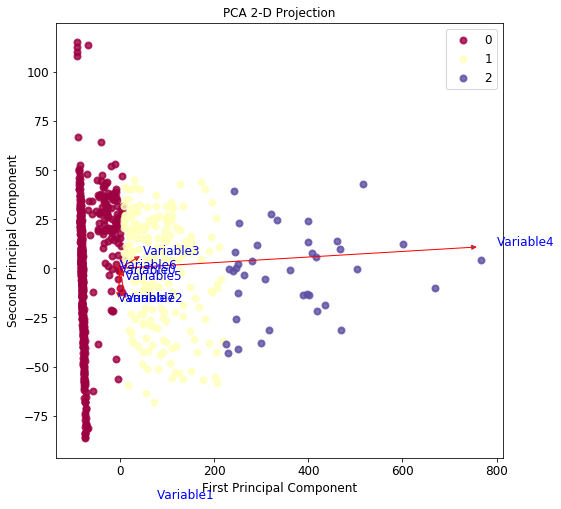

In [52]:
km3pca=PCA(random_state=99)
km3pca.fit(X)
skplt.decomposition.plot_pca_2d_projection(km3pca,X,yPred,
        biplot=True,
        figsize=(8,8),
        text_fontsize='large')

# Choosing the "Correct" Number of Clusters: Elbow Plot

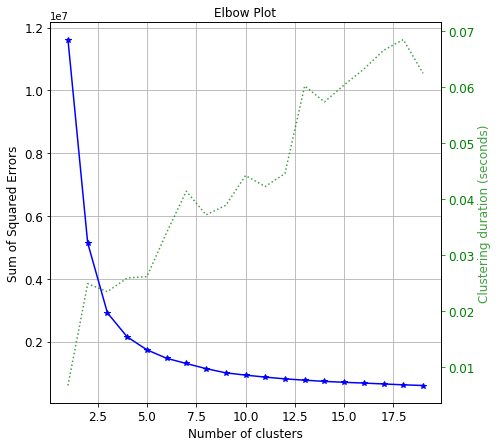

In [19]:
km=KMeans(random_state=99)
skplt.cluster.plot_elbow_curve(km,X,cluster_ranges=range(1,20),
                              figsize=(7,7),
                               text_fontsize='large')
plt.show();

# How Good Is That Clustering Solution: Silhouette Coefficient

**_Compared to what?_**

_Inertia_ here is sum of squared within cluster differences.

_Silhouette coefficients_ can be used to describe cluster homogeneity. See:

[Silhouette Method](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_silhouette_method).

[Silhouettes: A graphical aid to the interpretation and validation of cluster analysis](https://www.sciencedirect.com/science/article/pii/0377042787901257).

The range of possible values for the silhouette coefficient is $\big[-1,1\big]$.  larger is better.  Values $\lt$ 0 indicate observations in the "wrong" cluster.  A "good" cluster has no coefficients $\lt$ 0, and and average of cluster coefficients that's positive and "large."

### Silhouette Coefficients

In [20]:
print("Average Silhouette Coefficient: {:3.3f}".format(
      silhouette_score(X,yPred)))

Average Silhouette Coefficient: 0.510


### Describing Silhouette Coefficients

In [21]:
# get coefficients for each observation

silCoefs=silhouette_samples(X,yPred)
silDF=pd.DataFrame({'yPred':yPred,'silcoef':silCoefs})
silDF.groupby('yPred').describe()

silcoef                                                              \
        count      mean       std       min       25%       50%       75%   
yPred                                                                       
0       495.0  0.548746  0.163807 -0.008809  0.496852  0.622992  0.665629   
1       235.0  0.444012  0.173055  0.034683  0.309339  0.511324  0.589442   
2        38.0  0.422027  0.205847 -0.019027  0.235653  0.502882  0.609062   

                 
            max  
yPred            
0      0.699211  
1      0.642188  
2      0.630150

These coefficients can be plotted by cluster to help visualize a clustering solution.  More on this, below.

# Search for Number of Clusters Using Average Silhouette Coefficient

One way to find a "best" number of clusters is to compare one or more cluster quality measures across solutions that differ in their number of clusters.  Here's a K-means example using the average silhouette coefficient, from above.

### A Little Search for the Largest Average Silhouette Coefficient

In [22]:
def kmeanSilSearch(X,minN,maxN):
    '''
    Calculates mean sihouette scores for a range of kmeans solutions.
    Returns a Pandas DataFrame of results.
    Does no error checking or exception trapping.
    User beware!
    '''
    nClusters=range(minN,maxN+1)  # number of clusters range
    clustRes=[]   # results dict holder
    for nClust in nClusters:
        cRes=KMeans(nClust, random_state=99)
        yPred=cRes.fit_predict(X)
        resDict={'nclus':nClust,
                'meanSilScore':silhouette_score(X,yPred)
                }
        clustRes.append(resDict)
    return pd.DataFrame(clustRes)

In [23]:
clustResDF=kmeanSilSearch(X,2,10)

### Clustering Results, Sorted in Descending Value

In [24]:
clustResDF.sort_values('meanSilScore',ascending=False)

,meanSilScore,nclus
0,0.568790,2
1,0.510429,3
2,0.427819,4
3,0.393654,5
6,0.352629,8
7,0.338606,9
4,0.333512,6
5,0.333353,7
8,0.289905,10


### A Plot of the Average Silhouette Coefficient By Number of Clusters

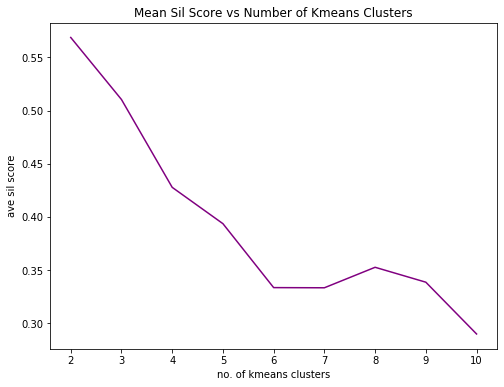

In [25]:
plt.figure(figsize=(8,6))
ax=sns.lineplot("nclus","meanSilScore",data=clustResDF,color="purple")
ax.set(xlabel='no. of kmeans clusters',ylabel='ave sil score')
plt.title('Mean Sil Score vs Number of Kmeans Clusters')
plt.show();

# UDU: Repeat the Above "Search for Best K" using different Cluster Quality Measures

Modify the function, above.  Also, if you can, add in the capability to return the "best" solution based on the metric you use.

You can find scikit-learn's clustering metrics [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.cluster).

# Rescaling Features

Some clustering algorithms will work better if the features are _scaled_ so as to have similar variances or ranges. This has sometimes been called "sphering the data."  Here we'll standardize the data (mean = 0, sd = 1), and then try clustering again.

See [StandardScaler on scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

## Standardizing X

In [29]:
stdScaler=preprocessing.StandardScaler()
XS=stdScaler.fit_transform(X)
XS.shape

(768, 8)

## Clustering Using Standardized Features

In [30]:
clustSResDF=kmeanSilSearch(XS,2,10)

In [31]:
clustSResDF.sort_values('meanSilScore',ascending=False)

,meanSilScore,nclus
2,0.201749,4
0,0.195654,2
3,0.189125,5
1,0.180360,3
5,0.168094,7
4,0.167942,6
6,0.162820,8
7,0.156201,9
8,0.148446,10


__Question__:  Are these silhouette coefficients comparable to those obtained above before standardizing the features?

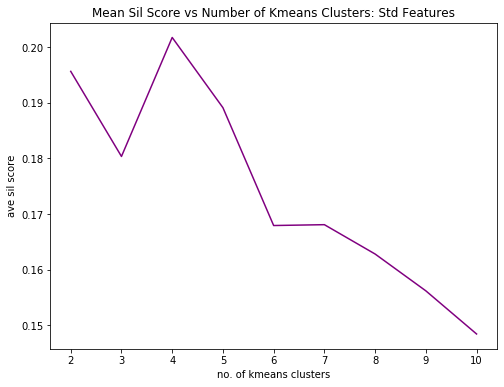

In [32]:
plt.figure(figsize=(8,6))
ax=sns.lineplot("nclus","meanSilScore",data=clustSResDF,color="purple")
ax.set(xlabel='no. of kmeans clusters',ylabel='ave sil score')
plt.title('Mean Sil Score vs Number of Kmeans Clusters: Std Features')
plt.show();

# Principal Components Analysis (PCA) for Data Reduction

PCA is used in ML applications as a _data reduction_ method.  It is also sometimes used as a preliminary processing step before clustering.  That's called "tandem clustering," and has been criticized by some based on the possibility that information will be lost.  But here we'll go ahead and "try it at home" just to see how it's done.

## PCA in a Nutshell

"Conventional" PCA is done using a matrix decomposition method called _singular value decomposition_ (SVD), or by eigenvalue decomposition, depending on whether the matrix is a rectangular data matrix, or a covariance or correlation matrix, respectively.  The result is a series of orthogonal vectors, or components, that are each weighted linear combinations of the data.  These components account for decreasing amounts of the total variation in the original data, from the most to the least. There can be as many components are there are features, or as there are observations, whichever is less.

Data reduction is accomplished by selecting up to some number of components that account for a specified total percentage of the variation in the data, or by selecting those components that have eigenvalues $\ge$ 1.0, given that the correlation matrix of the features is the input data.  The selected subset of components, and the scores on them, are used as features in subsequent analyses.

Here's where you can find PCA information on [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [33]:
# A complete PCA solution:
pca=PCA()
#
Xpca=pca.fit(XS)  # Note that here we are using the correlation matrix.

## Scree Plot

This is a plot of eigenvalue vs. component number.

A component with an eigenvalue = 1 accounts for as much variance as the average input feature. The sum of these eigenvalues should equal the number of features, rounding and truncation errors notwithstanding.

In [34]:
Xpca.explained_variance_
(Xpca.explained_variance_).sum()

array([2.09711056, 1.73346726, 1.03097228, 0.87667054, 0.76333832,
       0.68351839, 0.42036353, 0.40498938])

8.010430247718384

In [35]:
eigenDF=pd.DataFrame({'eigenvalue':Xpca.explained_variance_,
                     'component':range(1,9)})

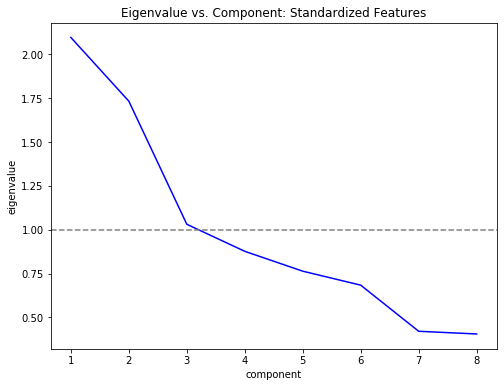

In [36]:
plt.figure(figsize=(8,6))
ax=sns.lineplot("component","eigenvalue",data=eigenDF,color="blue")
plt.axhline(1.0,color='grey',linestyle='--')
plt.title("Eigenvalue vs. Component: Standardized Features")
plt.show();

## Another Kind of Plot for Choosing the Number of Components

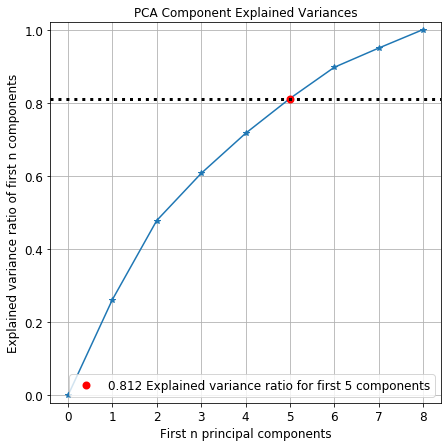

In [47]:
pcar=PCA(random_state=99)
pcar.fit(XS)
skplt.decomposition.plot_pca_component_variance(pcar,
                    figsize=(7,7),
                    text_fontsize='large',
                    target_explained_variance=0.80)
plt.show();

## Extracting Components

It appears that the number of components we should use is 3.

In [53]:
pca3=PCA(3)
XS3=pca3.fit_transform(XS)
XS3.shape

(768, 3)

# UDU:  K Means Clustering Using Reduced Data

Find your "best" clustering solution using the above PCA results.

# Plotting Silhouette Coefficients

I've grabbed some example code for producing silhouette plots.  One example is from [scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html), and versions of it can be found here in the notebook "plot_kmeans_silhouette_analysis.ipynb," and in a Python script file "plot_kmeans_silhouette_analysis.py."  They are the same code, from what I can tell.

Another example is here in the script file "another_plot_kmeans_silhouette_analysis.py."

And yet another is in the file "kmeansplots.py."

# UDU:  Produce a K Means Silhouette Plot

Adapt the code provided in one of the examples, above, and produce silhouette plots for a range of cluster numbers.  Use either the original or standardized diabetes data.